In [ ]:
!pip install XGBoost

In [ ]:
!pip install seaborn==0.9.0

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [4]:
df = pd.read_csv('s3://partly-cloudy-ml-inputs/WASHINGTON_every_6_hour_flat.csv')
df.head()

,localDateTime,Nx,Ny,Lat,Lon,geoEncode,NAME,iSSRs200430,iSSRs300430,meanTemp200430,meanTemp300430,meanRH_ice200430,meanRH_ice300430
0,2020-06-01 00:00:00,230,106,38.124552,-80.283553,dnybv,WASHINGTON,0,0,234.223667,221.513167,31.239167,47.148333
1,2020-07-14 12:00:00,230,106,38.124552,-80.283553,dnybv,WASHINGTON,0,0,238.427083,224.389833,25.554167,38.823333
2,2020-09-09 06:00:00,230,106,38.124552,-80.283553,dnybv,WASHINGTON,0,0,240.094833,227.039333,45.054167,78.146667
3,2020-10-09 18:00:00,230,106,38.124552,-80.283553,dnybv,WASHINGTON,0,0,239.067417,226.685000,82.413333,86.041667
4,2021-04-01 06:00:00,230,106,38.124552,-80.283553,dnybv,WASHINGTON,0,0,232.573750,222.432833,7.345833,11.363333


In [5]:
#Creating a subset of the dataframe - Going to just look at ISSRs at FL 300 to FL 370
df = df[['localDateTime', 'iSSRs300430','Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']]
df = df.rename(columns={'iSSRs300430': 'ISSRCount'})
df.head()

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
0,2020-06-01 00:00:00,0,230,106,221.513167,47.148333
1,2020-07-14 12:00:00,0,230,106,224.389833,38.823333
2,2020-09-09 06:00:00,0,230,106,227.039333,78.146667
3,2020-10-09 18:00:00,0,230,106,226.685000,86.041667
4,2021-04-01 06:00:00,0,230,106,222.432833,11.363333


In [6]:
#Convert variables into appropriate formats for analysis
#1. localDateTime -> Date object
df['localDateTime'] = pd.to_datetime(df['localDateTime'], infer_datetime_format=True)
#Check change has occured
#df.info()

In [7]:
#df.sort_values('localDateTime')

In [8]:
#test date is randomly picked - 2020/12/20
df = df[df.localDateTime <= '2020-11-15 00:00:00']
df = df[df.localDateTime >= '2020-08-14 00:00:00']
df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430
2,2020-09-09 06:00:00,0,230,106,227.039333,78.146667
3,2020-10-09 18:00:00,0,230,106,226.685000,86.041667
9,2020-09-18 18:00:00,0,230,106,226.392333,34.381667
10,2020-10-17 12:00:00,0,230,106,222.043667,40.095000
25,2020-08-28 12:00:00,0,230,106,229.528333,87.878333
...,...,...,...,...,...,...
1155632,2020-10-09 06:00:00,0,242,98,225.923667,79.755000
1155633,2020-11-03 06:00:00,0,242,98,221.317000,35.595000
1155638,2020-10-17 12:00:00,0,242,98,222.335333,31.998333
1155643,2020-08-22 12:00:00,0,242,98,227.044167,91.066667


In [9]:
features = ['Nx', 'Ny', 'meanTemp300430', 'meanRH_ice300430']
label = 'ISSRCount'
test_df = df[df.localDateTime >= '2020-11-14 00:00:00']
train_df = df[df.localDateTime < '2020-11-14 00:00:00']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [10]:
params = { 'max_depth': [3, 6, 10, 15],
           'learning_rate': [0.01, 0.2],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0),
           'colsample_bylevel': np.arange(0.4, 1.0),
           'n_estimators': [100, 500]}

In [11]:
xgbr = xgb.XGBRegressor(seed = 20)

In [12]:
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         n_iter=25,
                         verbose=1)

In [13]:
reg = clf.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='mae')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[0]	validation_0-mae:0.49323	validation_1-mae:0.43700
[1]	validation_0-mae:0.44343	validation_1-mae:0.38016
[2]	validation_0-mae:0.40356	validation_1-mae:0.33398
[3]	validation_0-mae:0.37200	validation_1-mae:0.30085
[4]	validation_0-mae:0.34674	validation_1-mae:0.27421
[5]	validation_0-mae:0.32643	validation_1-mae:0.25281
[6]	validation_0-mae:0.31023	validation_1-mae:0.23583
[7]	validation_0-mae:0.27352	validation_1-mae:0.20270
[8]	validation_0-mae:0.26322	validation_1-mae:0.19185
[9]	validation_0-mae:0.23582	validation_1-mae:0.16787
[10]	validation_0-mae:0.21404	validation_1-mae:0.14927
[11]	validation_0-mae:0.19691	validation_1-mae:0.13395
[12]	validation_0-mae:0.19262	validation_1-mae:0.12945
[13]	validation_0-mae:0.18909	validation_1-mae:0.12771
[14]	validation_0-mae:0.18641	validation_1-mae:0.12490
[15]	validation_0-mae:0.18423	validation_1-mae:0.12262
[16]	validation_0-mae:0.18247	validation_1-mae:0.12077
[17]	validati

In [17]:
print("Best parameters:", clf.best_params_)

Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4}


In [18]:
#print("Lowest RMSE:", (clf.best_score)**(1/2.0))

In [19]:
#reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
#reg.fit(X_train,
#        y_train,
#        eval_set=[(X_train, y_train), (X_test, y_test)],
#        eval_metric='mae')

In [20]:
y_pred = reg.predict(X_test)

In [21]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['y_pred'] = pd.Series(y_pred)

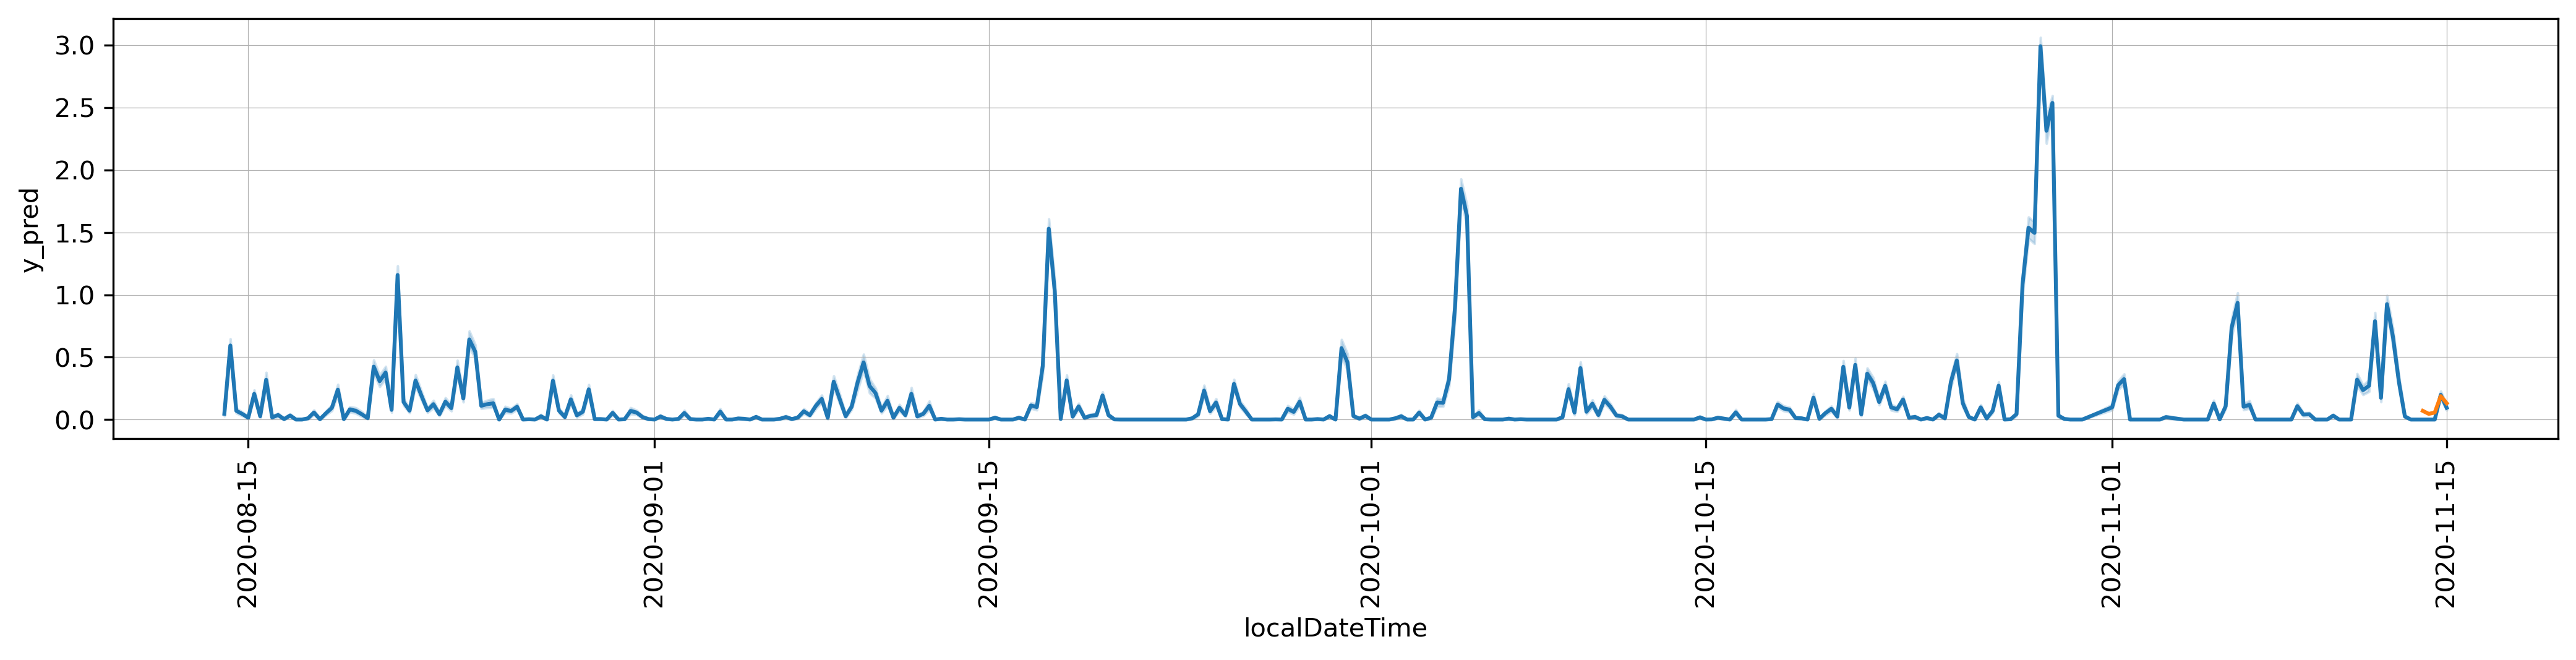

In [22]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=df, x='localDateTime',y='ISSRCount')
sns.lineplot(data=test_df, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [23]:
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-11-14 18:00:00,0,230,106,223.660167,71.748333,0.107533
1,2020-11-14 06:00:00,0,230,106,224.871667,71.285000,0.137516
2,2020-11-14 12:00:00,0,230,106,224.041667,64.128333,0.089416
3,2020-11-15 00:00:00,0,230,106,225.103000,55.971667,0.054069
4,2020-11-14 00:00:00,0,230,106,225.504667,53.806667,0.048939
...,...,...,...,...,...,...,...
3980,2020-11-14 18:00:00,0,242,98,224.139333,92.446667,0.617545
3981,2020-11-14 12:00:00,0,242,98,224.875000,65.718333,0.097110
3982,2020-11-14 06:00:00,0,242,98,225.840500,56.868333,0.042878
3983,2020-11-14 00:00:00,0,242,98,226.035833,62.983333,0.083111


In [24]:
test_df['y_pred'] = round(test_df['y_pred'],0)
test_df

,localDateTime,ISSRCount,Nx,Ny,meanTemp300430,meanRH_ice300430,y_pred
0,2020-11-14 18:00:00,0,230,106,223.660167,71.748333,0.0
1,2020-11-14 06:00:00,0,230,106,224.871667,71.285000,0.0
2,2020-11-14 12:00:00,0,230,106,224.041667,64.128333,0.0
3,2020-11-15 00:00:00,0,230,106,225.103000,55.971667,0.0
4,2020-11-14 00:00:00,0,230,106,225.504667,53.806667,0.0
...,...,...,...,...,...,...,...
3980,2020-11-14 18:00:00,0,242,98,224.139333,92.446667,1.0
3981,2020-11-14 12:00:00,0,242,98,224.875000,65.718333,0.0
3982,2020-11-14 06:00:00,0,242,98,225.840500,56.868333,0.0
3983,2020-11-14 00:00:00,0,242,98,226.035833,62.983333,0.0


In [25]:
test_df['y_pred'].describe()

count    3985.000000
mean        0.026851
std         0.161661
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: y_pred, dtype: float64

In [26]:
test_df['ISSRCount'].describe()

count    3985.000000
mean        0.058469
std         0.243065
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: ISSRCount, dtype: float64

In [27]:
test_df['localDateTime'] = pd.to_datetime(test_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts = test_df[['localDateTime', 'ISSRCount', 'y_pred']].copy()
print(df_ISSR_counts)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts.resample('D', on='localDateTime').sum()

           localDateTime  ISSRCount  y_pred
0    2020-11-14 18:00:00          0     0.0
1    2020-11-14 06:00:00          0     0.0
2    2020-11-14 12:00:00          0     0.0
3    2020-11-15 00:00:00          0     0.0
4    2020-11-14 00:00:00          0     0.0
...                  ...        ...     ...
3980 2020-11-14 18:00:00          0     1.0
3981 2020-11-14 12:00:00          0     0.0
3982 2020-11-14 06:00:00          0     0.0
3983 2020-11-14 00:00:00          0     0.0
3984 2020-11-15 00:00:00          1     0.0

[3985 rows x 3 columns]


,ISSRCount,y_pred
localDateTime,,
2020-11-14,158,103.0
2020-11-15,75,4.0


In [28]:
#Examines sum of ISSRs in 6 hour time intervals
df_sum = df_ISSR_counts.resample('6H', on='localDateTime').sum()
df_sum

,ISSRCount,y_pred
localDateTime,,
2020-11-14 00:00:00,0,8.0
2020-11-14 06:00:00,0,0.0
2020-11-14 12:00:00,0,0.0
2020-11-14 18:00:00,158,95.0
2020-11-15 00:00:00,75,4.0


In [29]:
# convert the index to column
df_sum.reset_index(inplace=True)
df_sum

,localDateTime,ISSRCount,y_pred
0,2020-11-14 00:00:00,0,8.0
1,2020-11-14 06:00:00,0,0.0
2,2020-11-14 12:00:00,0,0.0
3,2020-11-14 18:00:00,158,95.0
4,2020-11-15 00:00:00,75,4.0


In [30]:
train_df['localDateTime'] = pd.to_datetime(train_df['localDateTime']) 

#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
df_ISSR_counts_train = train_df[['localDateTime', 'ISSRCount']].copy()
print(df_ISSR_counts_train)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts_train.resample('D', on='localDateTime').sum()
df_sum_train = df_ISSR_counts_train.resample('6H', on='localDateTime').sum()

              localDateTime  ISSRCount
2       2020-09-09 06:00:00          0
3       2020-10-09 18:00:00          0
9       2020-09-18 18:00:00          0
10      2020-10-17 12:00:00          0
25      2020-08-28 12:00:00          0
...                     ...        ...
1155632 2020-10-09 06:00:00          0
1155633 2020-11-03 06:00:00          0
1155638 2020-10-17 12:00:00          0
1155643 2020-08-22 12:00:00          0
1155644 2020-09-04 00:00:00          0

[290108 rows x 2 columns]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [31]:
# convert the index to column
df_sum_train.reset_index(inplace=True)
df_sum_train

,localDateTime,ISSRCount
0,2020-08-14 00:00:00,37
1,2020-08-14 06:00:00,473
2,2020-08-14 12:00:00,56
3,2020-08-14 18:00:00,36
4,2020-08-15 00:00:00,12
...,...,...
363,2020-11-12 18:00:00,529
364,2020-11-13 00:00:00,241
365,2020-11-13 06:00:00,20
366,2020-11-13 12:00:00,0


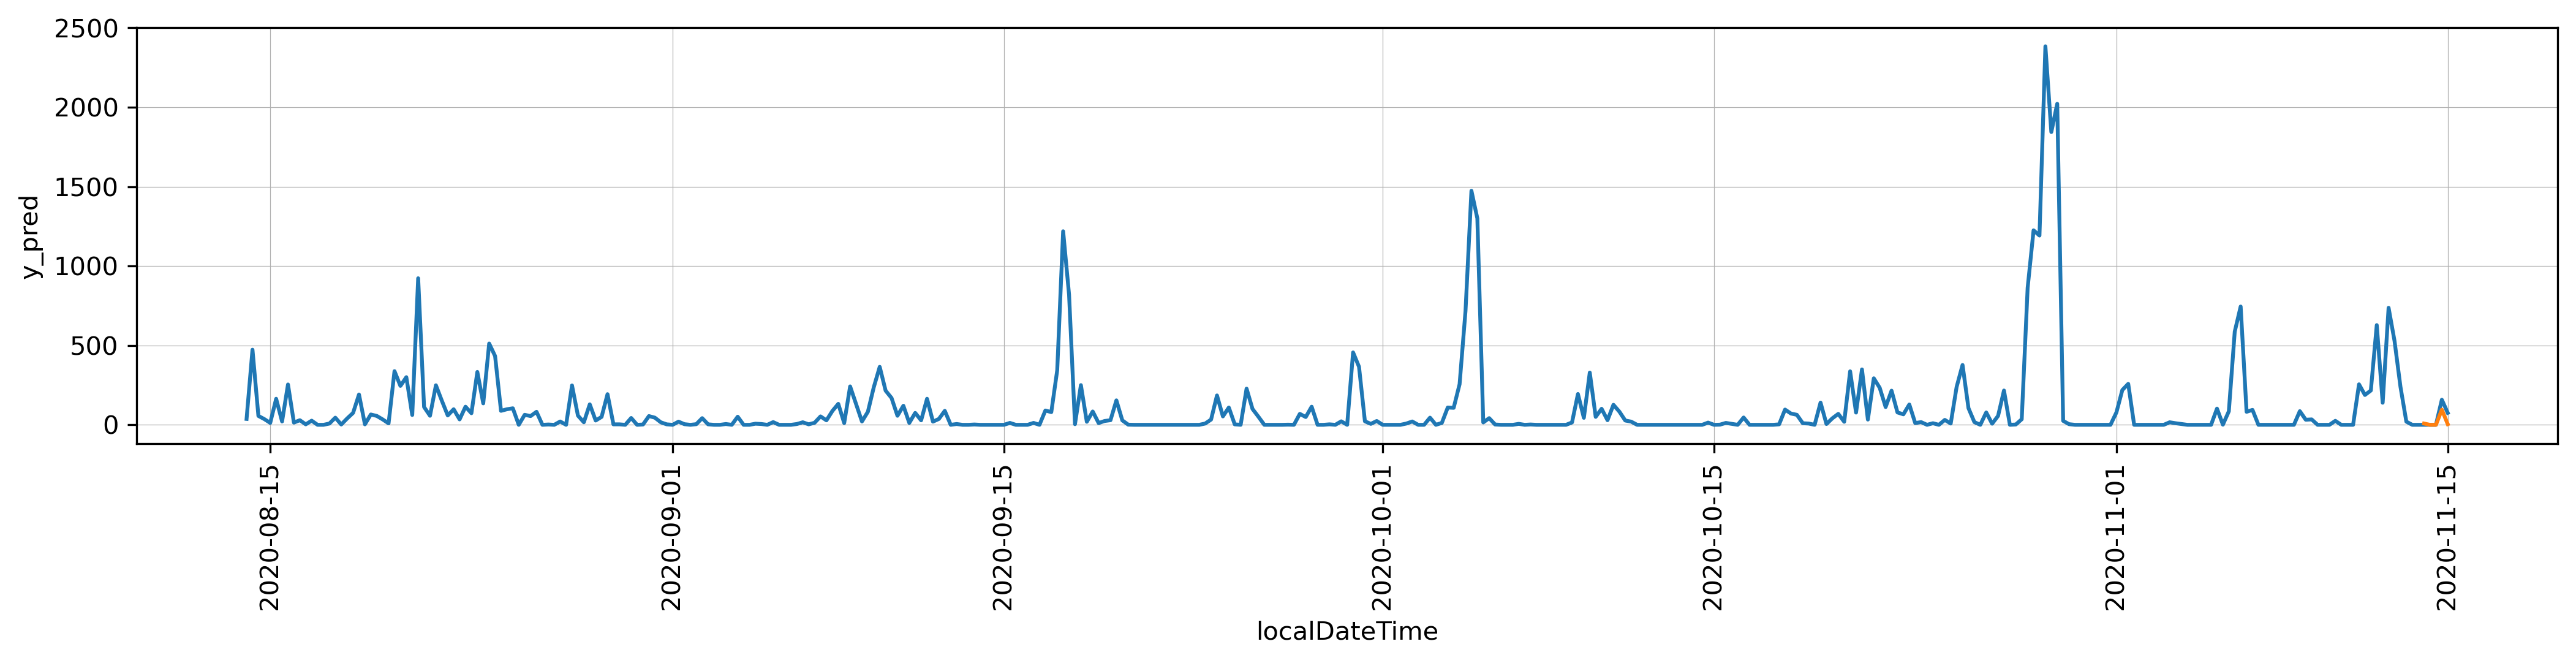

In [32]:
plt.rcParams.update({'figure.figsize': (17,3), 'figure.dpi': 300})
fit, ax = plt.subplots()
sns.lineplot(data=pd.concat([df_sum_train, df_sum]), x='localDateTime',y='ISSRCount')
sns.lineplot(data=df_sum, x='localDateTime',y='y_pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [33]:
confusion_matrix = pd.crosstab(test_df['ISSRCount'], test_df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0.0,1.0
Actual,,
0,3727,33
1,151,66
2,0,8


In [34]:
#from sklearn.metrics import plot_confusion_matrix
#disp = plot_confusion_matrix(reg, X_test, y_test,
#                           display_labels = label,
#                           cmap = plt.cm.Blues)
#plt.show()

In [35]:
# For predicted value 0:
TP=3727
TN=74   #=66+8
FP=151  #=151
FN=33   #=1

In [36]:
# true positive rate
TP_rate = TP/(TP+FN)
print("True positive: %.2f%%" % (TP_rate* 100.0))
#Specificity or true negative rate
#TN_rate = TN/(TN+FP) 
#print("True negative: %.2f%%" % (TN_rate* 100.0))
# Precision or positive predictive value
Precision_rate = TP/(TP+FP)
print("Precision: %.2f%%" % (Precision_rate* 100.0))
# Negative predictive value
#NP_rate = TN/(TN+FN)
#print("Negative predictive: %.2f%%" % (NP_rate * 100.0))
# Fall out or false positive rate
FP_rate = FP/(FP+TN)
print("False Positive: %.2f%%" % (FP_rate * 100.0))
# False negative rate
FN_rate = FN/(TP+FN)
print("False Negative: %.2f%%" % (FN_rate * 100.0))
# False discovery rate
#FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy for count zero: %.2f%%" % (ACC * 100.0))

True positive: 99.12%
Precision: 96.11%
False Positive: 67.11%
False Negative: 0.88%
Overall accuracy for count zero: 95.38%


In [37]:
from sklearn.metrics import accuracy_score

In [38]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.18%


In [39]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print('MAE: ', mae)

MAE:  0.04818067754077792
